In [1]:
import numpy as np

%matplotlib ipympl
import matplotlib.pyplot as plt

I don't understand why you need to run this command twice to get an interactive matplotlib display

In [2]:
%matplotlib ipympl

In [3]:
import lsst.daf.persistence        as dafPersist
import lsst.pex.exceptions         as pexExcept

import lsst.afw.display            as afwDisplay
import lsst.daf.base               as dafBase

import lsst.afw.image              as afwImage
import lsst.afw.geom               as afwGeom
import lsst.afw.table              as afwTable

import lsst.meas.algorithms        as measAlg

#### Load the high-level "tasks" that process the pixels

In [4]:
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.deblender               import SourceDeblendTask
from lsst.meas.base                    import SingleFrameMeasurementTask

#### Setup the displays (by default an interface to ds9, which won't work in the LSP)

In [5]:
afwDisplay.setDefaultBackend("matplotlib")

## Create the tasks

In [6]:
schema = afwTable.SourceTable.makeMinimalSchema()
algMetadata = dafBase.PropertyList()

config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask =         CharacterizeImageTask(None, config=config)

sourceDetectionTask =   SourceDetectionTask(schema=schema)

sourceDeblendTask =     SourceDeblendTask(schema=schema)

if False:
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema,
                                                       algMetadata=algMetadata)
else:
    config = SingleFrameMeasurementTask.ConfigClass()
    config.slots.apFlux = 'base_CircularApertureFlux_12_0'
    
    if True:    # Warning:  this takes too long -- be prepared to wait when running sourceMeasurementTask
        import lsst.meas.modelfit
        config.plugins.names |= ["modelfit_DoubleShapeletPsfApprox", "modelfit_CModel"]
        config.slots.modelFlux = 'modelfit_CModel'
        #config.catalogCalculation.plugins['base_ClassificationExtendedness'].fluxRatio = 0.985
        
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config,
                                                       algMetadata=algMetadata)

## Time to process some data

#### Read the input data

In [7]:
butler = dafPersist.Butler("/datasets/hsc/repo/rerun/RC/w_2019_18/DM-19151")

In [8]:
dataId = dict(visit=1232, ccd=51)
exposure = butler.get('calexp', dataId)

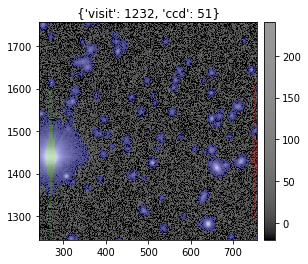

In [9]:
disp = afwDisplay.Display(reopenPlot=True, fastMaskDisplay=True)

disp.scale('asinh', -20, 30, Q=8)
disp.mtv(exposure, title=dataId)

disp.zoom(8, 500, 1500);

#### Create the output table

In [10]:
tab = afwTable.SourceTable.make(schema)

### Process the pixels

##### Characterise the exposure (e.g. estimate the PSF)

In [11]:
result = charImageTask.run(exposure)

##### Detect objects (`sources')

In [12]:
result = sourceDetectionTask.run(tab, exposure)
sources = result.sources

##### Deblend overlapping objects

In [13]:
sourceDeblendTask.run(exposure, sources)

##### Measure the objects' properties

In [14]:
sourceMeasurementTask.run(sources, exposure)

#### Write the results to a FITS file (if desired)

In [15]:
if False:
    fitsTableFile = "outputTable.fits"
    sources.writeFits(fitsTableFile)

    exposure.writeFits("example1-out.fits")
else:
    fitsTableFile = None

## OK, we've finished the image processing.

We have our list of sources, but it's not currently continuous in memory

In [16]:
try:
    sources.get("id")
except Exception as e:
    print(e)


  File "include/lsst/afw/table/BaseColumnView.h", line 211, in static lsst::afw::table::BaseColumnView lsst::afw::table::BaseColumnView::make(const std::shared_ptr<lsst::afw::table::BaseTable>&, InputIterator, InputIterator) [with InputIterator = lsst::afw::table::CatalogIterator<__gnu_cxx::__normal_iterator<const std::shared_ptr<lsst::afw::table::SourceRecord>*, std::vector<std::shared_ptr<lsst::afw::table::SourceRecord>, std::allocator<std::shared_ptr<lsst::afw::table::SourceRecord> > > > >]
    Record data is not contiguous in memory. {0}
lsst::pex::exceptions::RuntimeError: 'Record data is not contiguous in memory.'



We can fix this with a deep copy

In [17]:
sources = sources.copy(True)

In [18]:
if fitsTableFile is not None:
    sources = afwTable.SourceCatalog.readFits(fitsTableFile)

## Look at the results

In [19]:
import lsst.afw.display.utils as afwDisplayUtils

Define a boolean array that tells us which objects are 'good'; in this case:
 - No saturated pixels near their centres
 - terminal objects that haven't been further deblended

In [20]:
good = np.logical_and.reduce([sources.get('base_PixelFlags_flag_interpolatedCenter') == 0,
                              sources.get("deblend_nChild") == 0,
                              ])

#### Look at how well the aperture photometry agrees with the PSF measurements

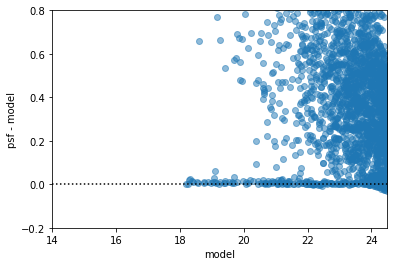

In [21]:
if False:
    apMag = exposure.getPhotoCalib().instFluxToMagnitude(sources, 'base_CircularApertureFlux_12_0')
else:
    apMag = exposure.getPhotoCalib().instFluxToMagnitude(sources, 'slot_ApFlux')
  
try:
    modelMag = exposure.getPhotoCalib().instFluxToMagnitude(sources, 'modelfit_CModel')
except pexExcept.NotFoundError:
    modelMag = None

psfMag = exposure.getPhotoCalib().instFluxToMagnitude(sources, 'slot_PsfFlux')

if False or modelMag is None:
    mag1, str1 = apMag, "ap"
else:
    mag1, str1 = modelMag, "model"
mag2, str2 = psfMag, "psf"

plt.close(1); plt.figure(1)
plt.plot(mag1[good], (mag2 - mag1)[good], 'o', alpha=0.5)

plt.axhline(0.0, ls=':', color='black')
plt.xlim(14, 24.5)
plt.ylim(-0.2, 0.8)

plt.xlabel(str1)
plt.ylabel(f"{str2} - {str1}")

plt.show()

This doesn't look like modern CCD data as there's no brighter-fatter effect.  That's because we corrected it at the pixel level as part of the instrumental signature effect.

## What photometry is available?

In [22]:
for k in sources.getSchema().extract("*_instFlux").keys():
    if "slot" not in k and "Blendedness" not in k:
        print(k)

deblend_psf_instFlux
base_SdssShape_instFlux
base_CircularApertureFlux_3_0_instFlux
base_CircularApertureFlux_4_5_instFlux
base_CircularApertureFlux_6_0_instFlux
base_CircularApertureFlux_9_0_instFlux
base_CircularApertureFlux_12_0_instFlux
base_CircularApertureFlux_17_0_instFlux
base_CircularApertureFlux_25_0_instFlux
base_CircularApertureFlux_35_0_instFlux
base_CircularApertureFlux_50_0_instFlux
base_CircularApertureFlux_70_0_instFlux
base_GaussianFlux_instFlux
base_LocalBackground_instFlux
base_PsfFlux_instFlux
modelfit_CModel_initial_instFlux
modelfit_CModel_exp_instFlux
modelfit_CModel_dev_instFlux
modelfit_CModel_instFlux


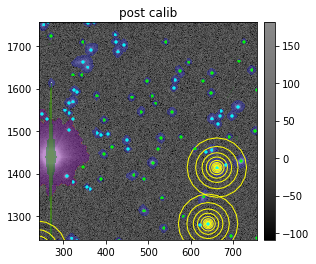

In [30]:
disp2 = afwDisplay.Display(2, reopenPlot=True)

disp2.setMaskPlaneColor("CROSSTALK", afwDisplay.IGNORE)   # I don't care about crosstalk-corrected pixels

disp2.scale('asinh', 'zscale', Q=4)
disp2.mtv(exposure, title='post calib')
disp2.zoom(8, 500, 1500)

# Overlay something about the measurements
disp2.erase()
with disp2.Buffering():
    for s in sources[good]:
        disp2.dot('+', *s.getCentroid(),
                  ctype=afwDisplay.GREEN if s.get("parent") == 0 else afwDisplay.CYAN)
        
# and some apertures used for photometry
radii = algMetadata.getArray("base_CircularApertureFlux_radii")

with disp2.Buffering():
    for s in sources[good]:
        if exposure.getPhotoCalib().instFluxToMagnitude(s, 'slot_ApFlux').value < 20.0:
            for radius in radii:
                disp2.dot('o', *s.getCentroid(), size=radius, ctype=afwDisplay.YELLOW)

### Astropy

In [26]:
sources[good].copy(deep=True).asAstropy()

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,modelfit_DoubleShapeletPsfApprox_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,modelfit_DoubleShapeletPsfApprox_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,modelfit_DoubleShapeletPsfApprox_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,modelfit_DoubleShapeletPsfApprox_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,modelfit_DoubleShapeletPsfApprox_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,modelfit_DoubleShapeletPsfApprox_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_xx,base_Blendedness_abs_parent_yy,base_Blendedness_abs_parent_xy,base_Blendedness_flag,base_Blend